## Análise exploratória dos dados e treinamento da rede neural MLP no Dataset Titanic - Terceira Avaliação Redes Neurais
### Discente: João Pedro de Alcântara Lima

#### 1. Análise Exploratória dos Dados

O processo se inicia com a análise quantitativa e relativa da sobrevivência (`Survived`) em relação ao sexo (`Sex`). Foram calculadas tanto as contagens absolutas quanto os percentuais de sobreviventes para cada sexo, permitindo identificar possíveis desbalanceamentos entre os grupos.
#### 2. Criação da Variável Combinada `SurvivedPclass`
Em seguida, foram gerados gráficos para visualizar:
- A distribuição dos passageiros por classe (`Pclass`) e sexo.
- A distribuição da nova variável combinada `SurvivedPclass` por sexo, que representa a combinação entre sobrevivência e classe social.

Essas visualizações evidenciam o desbalanceamento de classes, especialmente quando se observa a sobrevivência em função do sexo e da classe.

Para mitigar o desbalanceamento observado, foi criada a variável `SurvivedPclass`, que combina as informações de sobrevivência e classe social. Essa abordagem permite que o modelo aprenda com as classes já balanceadas entre os diferentes grupos de passageiros.
#### 3. Treinamento da rede MLP

- **Uma camada oculta com 10 neurônios**
- **Otimizador Adam**
- **Até 1000 iterações**

#### 4. Avaliação do Modelo

O desempenho do modelo foi avaliado no próprio conjunto de treino, extraindo novamente o valor de `Survived` a partir da previsão de `SurvivedPclass`. Foram calculadas as principais métricas de classificação:
- **Acurácia**
- **Precisão**
- **Recall**
- **F1-score**

Essas métricas permitem avaliar o quanto o modelo conseguiu aprender os padrões de sobrevivência, considerando o balanceamento promovido pela variável combinada.


In [31]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt


Contagem absoluta de sobreviventes por sexo:
Survived    0    1
Sex               
female     81  233
male      468  109

Percentual de sobreviventes por sexo:
Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815


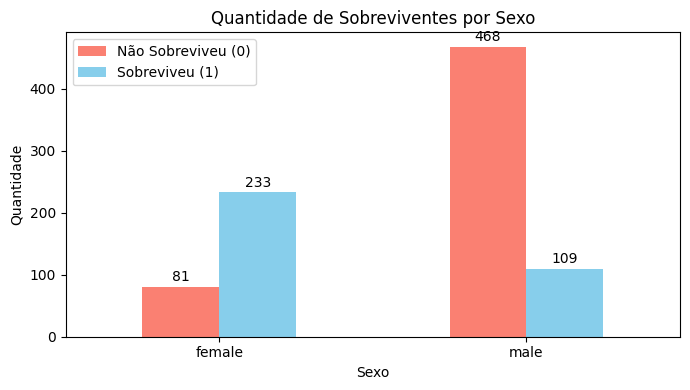

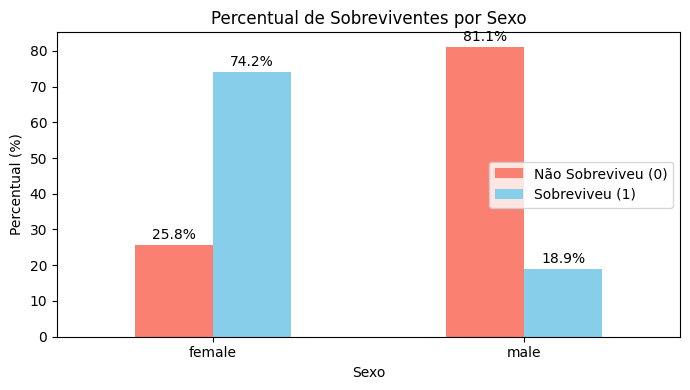

In [32]:
# Carregar os dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 1. Análise quantitativa e relativa de Survived em relação ao Sex
survived_sex_counts = train_df.groupby('Sex')['Survived'].value_counts().unstack().fillna(0)
survived_sex_percent = survived_sex_counts.div(survived_sex_counts.sum(axis=1), axis=0) * 100

print("Contagem absoluta de sobreviventes por sexo:")
print(survived_sex_counts)
print("\nPercentual de sobreviventes por sexo:")
print(survived_sex_percent)

# Plotagem da quantidade absoluta
ax1 = survived_sex_counts.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Quantidade de Sobreviventes por Sexo')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax1.containers:
    ax1.bar_label(container, padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

# Plotagem do percentual
ax2 = survived_sex_percent.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Percentual de Sobreviventes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

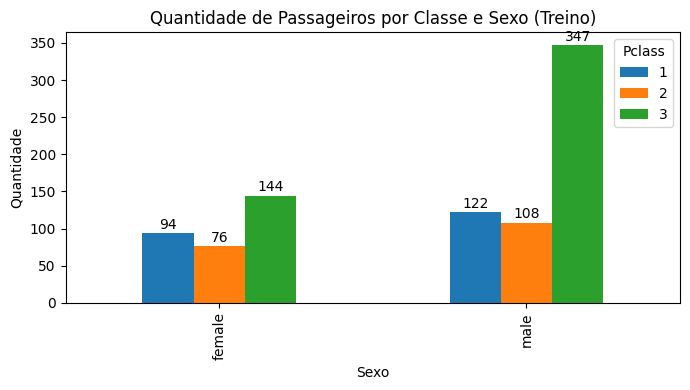

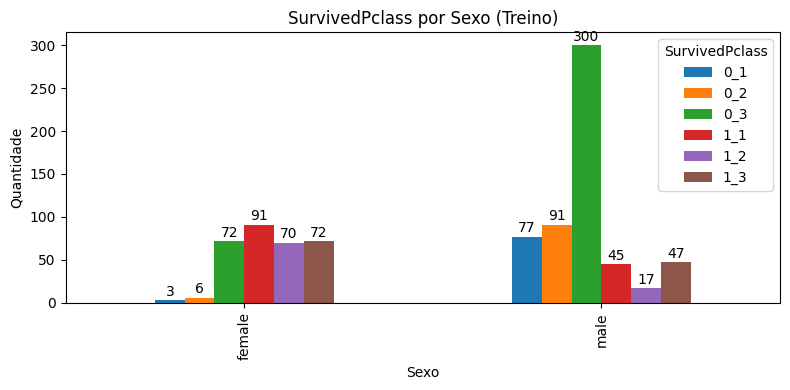

In [33]:
ct = pd.crosstab(train_df['Sex'], train_df['Pclass'])

fig, ax = plt.subplots(figsize=(7,4))
bars = ct.plot(kind='bar', ax=ax) 

plt.title('Quantidade de Passageiros por Classe e Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

# 3. Criar a nova classe combinada SurvivedPclass
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

ct = pd.crosstab(train_df['Sex'], train_df['SurvivedPclass'])

fig, ax = plt.subplots(figsize=(8,4))
bars = ct.plot(kind='bar', ax=ax) 

plt.title('SurvivedPclass por Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='SurvivedPclass')
plt.tight_layout()
plt.show()

In [34]:
# Codificar a variável 'Sex'
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# Criar a variável combinada 'SurvivedPclass'
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

# Oversampling para balancear as classes
target = 'SurvivedPclass'
max_count = train_df[target].value_counts().max()
train_df_balanced = pd.concat([
    group.sample(max_count, replace=True, random_state=42)
    for _, group in train_df.groupby(target)
])


In [35]:
# Definir variáveis preditoras e alvo
features = ['Sex', 'Pclass']
X_train = train_df_balanced[features]
y_train = train_df_balanced['SurvivedPclass']

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_df[features])


In [36]:
# Treinar o modelo MLP com logs
mlp_model = MLPClassifier(
    hidden_layer_sizes=(10,),
    max_iter=1000,
    solver='adam',
    early_stopping=False,
    verbose=True,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)


Iteration 1, loss = 1.77889638
Iteration 2, loss = 1.73907361
Iteration 3, loss = 1.70222412
Iteration 4, loss = 1.66711542
Iteration 5, loss = 1.63358200
Iteration 6, loss = 1.60181689
Iteration 7, loss = 1.57176384
Iteration 8, loss = 1.54024248
Iteration 9, loss = 1.50835241
Iteration 10, loss = 1.47725803
Iteration 11, loss = 1.44745289
Iteration 12, loss = 1.41802126
Iteration 13, loss = 1.38964663
Iteration 14, loss = 1.36225885
Iteration 15, loss = 1.33507899
Iteration 16, loss = 1.30457967
Iteration 17, loss = 1.27334666
Iteration 18, loss = 1.24339123
Iteration 19, loss = 1.21415203
Iteration 20, loss = 1.18583520
Iteration 21, loss = 1.15809987
Iteration 22, loss = 1.13129228
Iteration 23, loss = 1.10516080
Iteration 24, loss = 1.07956361
Iteration 25, loss = 1.05468722
Iteration 26, loss = 1.03101885
Iteration 27, loss = 1.00785831
Iteration 28, loss = 0.98560190
Iteration 29, loss = 0.96397757
Iteration 30, loss = 0.94333896
Iteration 31, loss = 0.92364525
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42,
              verbose=True)

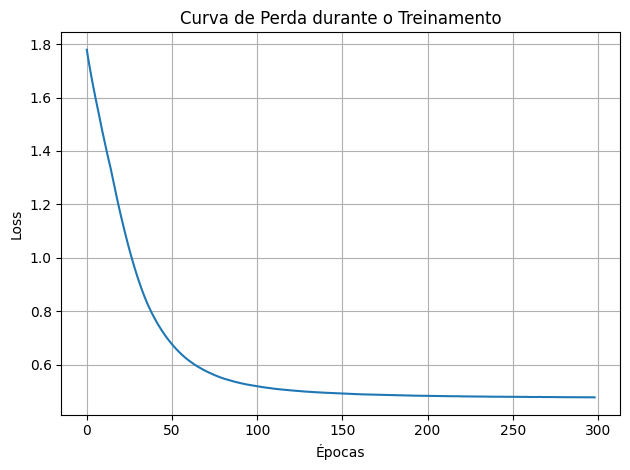

In [37]:
# Plotar curva de perda
plt.plot(mlp_model.loss_curve_)
plt.title("Curva de Perda durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# Prever no conjunto de teste
test_df['SurvivedPclass_pred'] = mlp_model.predict(X_test_scaled)

# Extrair a variável 'Survived' da previsão
test_df['Survived'] = test_df['SurvivedPclass_pred'].str[0].astype(int)

# Gerar arquivo de submissão
submission = test_df[['PassengerId', 'Survived']]
submission.to_csv('mlp_submission.csv', index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [39]:
# Avaliação no conjunto de treino balanceado
train_df_balanced['SurvivedPclass_pred'] = mlp_model.predict(X_train_scaled)
train_df_balanced['Survived_pred'] = train_df_balanced['SurvivedPclass_pred'].str[0].astype(int)

y_true = train_df_balanced['Survived']
y_pred = train_df_balanced['Survived_pred']

# Métricas de avaliação
print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precisão: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred))


Acurácia: 0.7953
Precisão: 0.8698
Recall: 0.6944

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.90      0.81      1116
           1       0.87      0.69      0.77      1116

    accuracy                           0.80      2232
   macro avg       0.81      0.80      0.79      2232
weighted avg       0.81      0.80      0.79      2232



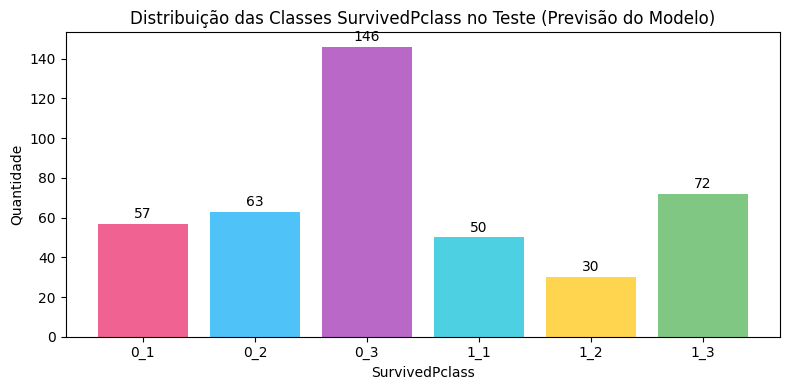

In [40]:
class_counts_test = test_df['SurvivedPclass_pred'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(class_counts_test.index, class_counts_test.values, color=['#F06292', '#4FC3F7', '#BA68C8', '#4DD0E1', '#FFD54F', '#81C784'])
ax.set_title('Distribuição das Classes SurvivedPclass no Teste (Previsão do Modelo)')
ax.set_ylabel('Quantidade')
ax.set_xlabel('SurvivedPclass')
ax.bar_label(bars, padding=2)
plt.tight_layout()
plt.show()

### Referências bibliográficas

- KAGGLE. Titanic - Machine Learning from Disaster. Disponível em: <https://www.kaggle.com/c/titanic>. Acesso em: 04 jul. 2025.

- TAVARES, Lucas. Dados desbalanceados: o que são e como evitá-los. *Turing Talks*, Medium, 2020. Disponível em: <https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b>. Acesso em: 04 jul. 2025.

- Pandas: Python Data Analysis Library. Disponível em: <https://pandas.pydata.org/>. Acesso em: 04 jul. 2025.

- Scikit-learn: Machine Learning in Python. Disponível em: <https://scikit-learn.org/stable/>. Acesso em: 04 jul. 2025.